In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import numpy as np
%matplotlib inline

In [7]:
# Define some global constants here
w, h = 1600, 900

# Custom colourmaps
# https://matplotlib.org/gallery/images_contours_and_fields/custom_cmap.html

# Similar to Alto's Odyssey
sky1 = [
    (0.0, [0.24, 0.25, 0.36]), # top of sky
    (0.5, [0.60, 0.42, 0.61]), # middle of sky
    (1.0, [0.94, 0.62, 0.68])  # bottom of sky (horizon)
]

# https://www.color-hex.com/color-palette/42455
sky2 = [
    (0.00, [0.27, 0.25, 0.43]),
    (0.70, [0.75, 0.30, 0.39]),
    (0.85, [0.88, 0.43, 0.34]),
    (0.95, [0.91, 0.67, 0.17]),
    (1.00, [0.94, 0.84, 0.41])
]

# Dark grey to blue
sky3 = [
    (0.00, [0.10, 0.10, 0.10]),
    (1.00, [0.20, 0.24, 0.38])
]

sky1_cmap = LinearSegmentedColormap.from_list('sky1', sky1)
sky2_cmap = LinearSegmentedColormap.from_list('sky2', sky2)
sky3_cmap = LinearSegmentedColormap.from_list('sky2', sky3)

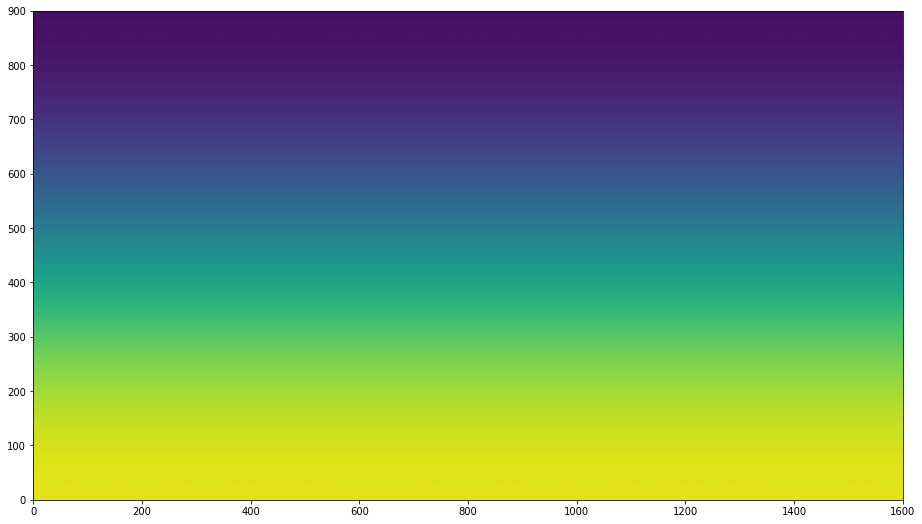

In [8]:
def draw_sky(width=1600, height=900, cmap=plt.cm.viridis):
    plt.xlim(0,width)
    plt.ylim(0,height)
    plt.imshow([[0, 0],[1, 1]], cmap=cmap, interpolation='bicubic', extent=plt.xlim()+plt.ylim(), zorder=0)
    return True

plt.figure(figsize=(16,9))
draw_sky()
plt.show()

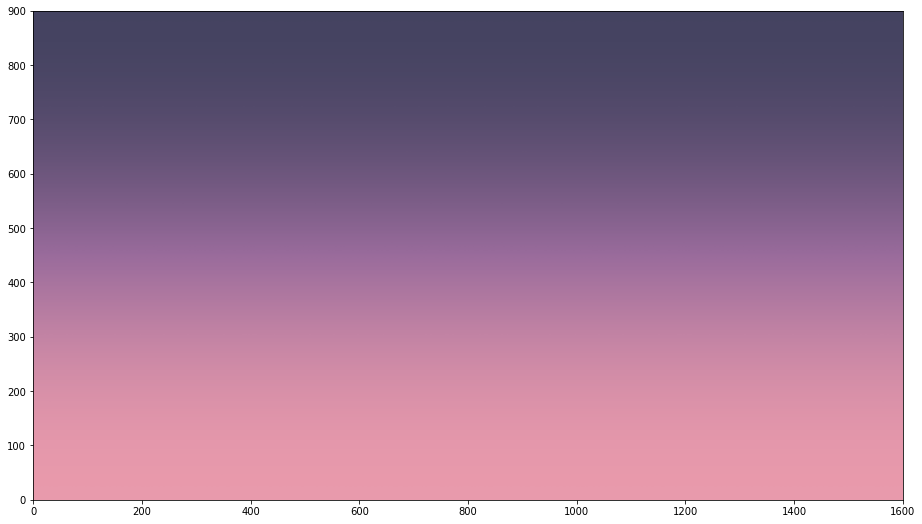

In [9]:
plt.figure(figsize=(16,9))
draw_sky(w, h, sky1_cmap)
plt.show()

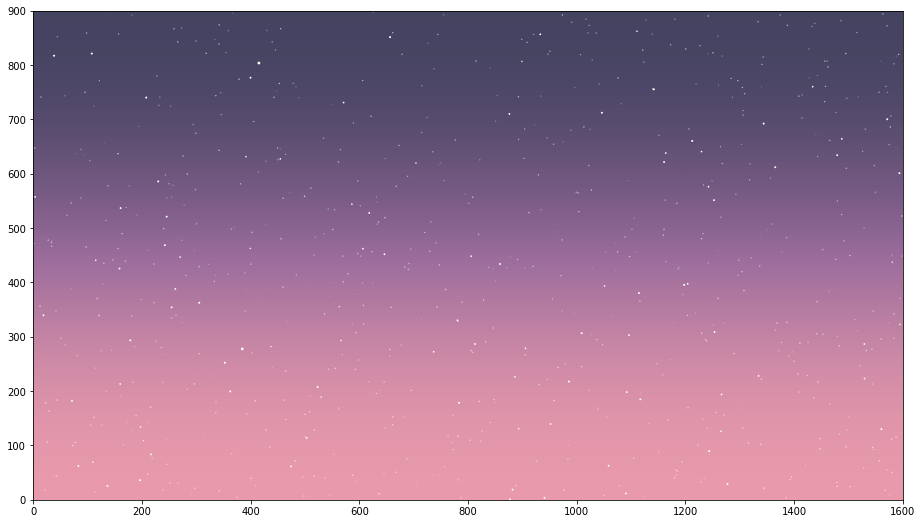

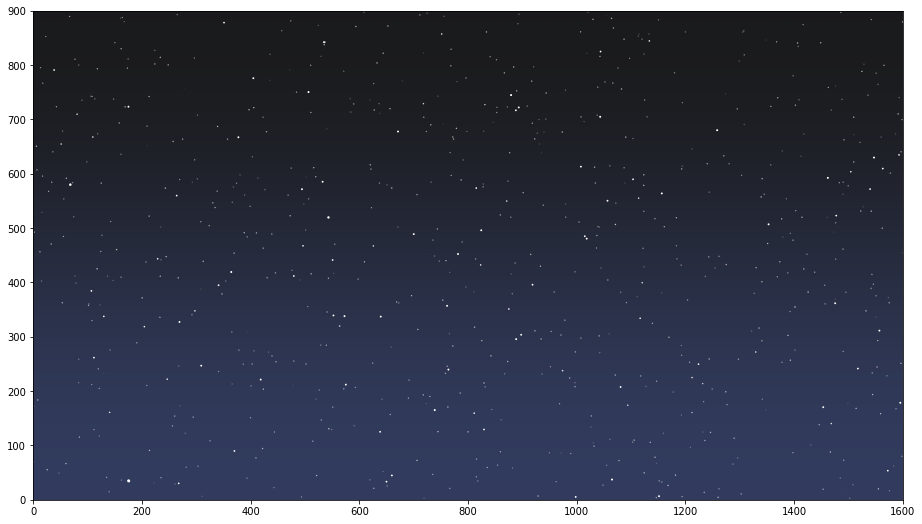

In [10]:
# Draw n stars at random positions, with random sizes
def draw_uniform_stars(w, h, n=100, max_size=5, col='w'):
    stars = np.random.random((n,3)) * np.array([w, h, max_size])
    plt.scatter(stars[:,0], stars[:,1], s=stars[:,2], c=col, zorder=1)
    return stars

# Draw n stars at random positions, but with size/number ratios to simulate a real star brightness distribution
def draw_stars(w, h, n=750, max_size=5, col='w', n_ratios=[0.005,0.15,0.85], s_ratios=[1.0, 0.2, 0.02], **kwargs):
    # Calculate the number of stars in each size group
    n_large = max(1,int(n*n_ratios[0]))
    n_med   = int(n*n_ratios[1])
    n_small = int(n*n_ratios[2])
    # Calculate the size of each star group
    s_large = s_ratios[0]*max_size
    s_med   = s_ratios[1]*max_size
    s_small = s_ratios[2]*max_size
    # Draw them
    draw_uniform_stars(w, h, n=n_large, col=col, max_size=s_large)
    draw_uniform_stars(w, h, n=n_med  , col=col, max_size=s_med)
    draw_uniform_stars(w, h, n=n_small, col=col, max_size=s_small)
    
# Test it
plt.figure(figsize=(16,9))
draw_sky(w, h, sky1_cmap)
draw_stars(w, h)

plt.figure(figsize=(16,9))
draw_sky(w, h, sky3_cmap)
draw_stars(w, h)

plt.show()

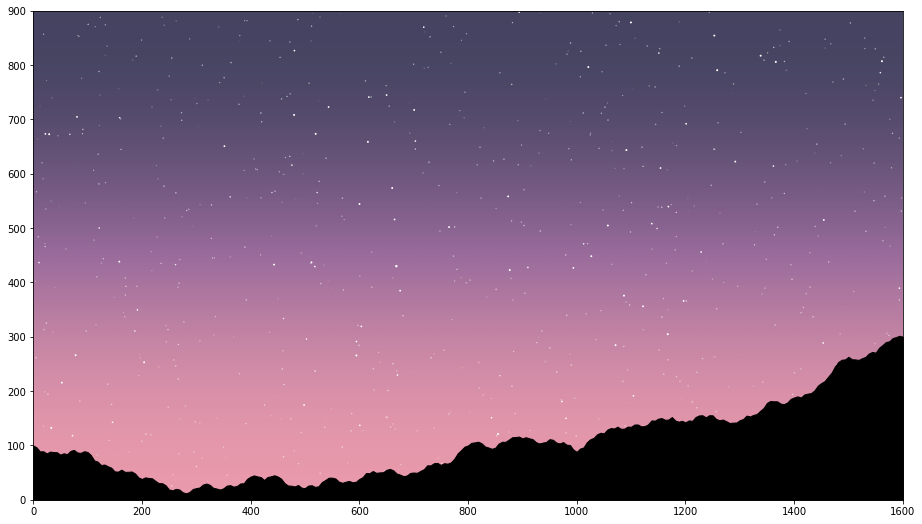

In [11]:
# Terrain
# From https://bitesofcode.wordpress.com/2016/12/23/landscape-generation-using-midpoint-displacement/
import bisect

# Iterative midpoint vertical displacement
def midpoint_displacement(start, end, roughness, vertical_displacement=None, num_of_iterations=16):
    """
    Given a straight line segment specified by a starting point and an endpoint
    in the form of [starting_point_x, starting_point_y] and [endpoint_x, endpoint_y],
    a roughness value > 0, an initial vertical displacement and a number of
    iterations > 0 applies the  midpoint algorithm to the specified segment and
    returns the obtained list of points in the form
    points = [[x_0, y_0],[x_1, y_1],...,[x_n, y_n]]
    """
    # Final number of points = (2^iterations)+1
    if vertical_displacement is None:
        # if no initial displacement is specified set displacement to:
        #  (y_start+y_end)/2
        vertical_displacement = (start[1]+end[1])/2
    # Data structure that stores the points is a list of lists where
    # each sublist represents a point and holds its x and y coordinates:
    # points=[[x_0, y_0],[x_1, y_1],...,[x_n, y_n]]
    #              |          |              |
    #           point 0    point 1        point n
    # The points list is always kept sorted from smallest to biggest x-value
    points = [start, end]
    iteration = 1
    while iteration <= num_of_iterations:
        # Since the list of points will be dynamically updated with the new computed
        # points after each midpoint displacement it is necessary to create a copy
        # of the state at the beginning of the iteration so we can iterate over
        # the original sequence.
        # Tuple type is used for security reasons since they are immutable in Python.
        points_tup = tuple(points)
        for i in range(len(points_tup)-1):
            # Calculate x and y midpoint coordinates:
            # [(x_i+x_(i+1))/2, (y_i+y_(i+1))/2]
            midpoint = list(map(lambda x: (points_tup[i][x]+points_tup[i+1][x])/2,
                                [0, 1]))
            # Displace midpoint y-coordinate
            midpoint[1] += np.random.choice([-vertical_displacement,vertical_displacement])
            # Insert the displaced midpoint in the current list of points         
            bisect.insort(points, midpoint)
            # bisect allows to insert an element in a list so that its order
            # is preserved.
            # By default the maintained order is from smallest to biggest list first
            # element which is what we want.
        # Reduce displacement range
        vertical_displacement *= 2 ** (-roughness)
        # update number of iterations
        iteration += 1
    return np.array(points)

def draw_terrain(start, end, roughness, vertical_displacement=None, num_of_iterations=16, col='k'):
    layer = midpoint_displacement(start, end, roughness, vertical_displacement, num_of_iterations)
    plt.fill_between(layer[:,0], layer[:,1], y2=0, color=col, zorder=3)
    return layer

plt.figure(figsize=(16,9))
draw_sky(w, h, sky1_cmap)
draw_stars(w, h)
draw_terrain([0, 100], [w, 300], 0.8, 100, 8)

plt.show()

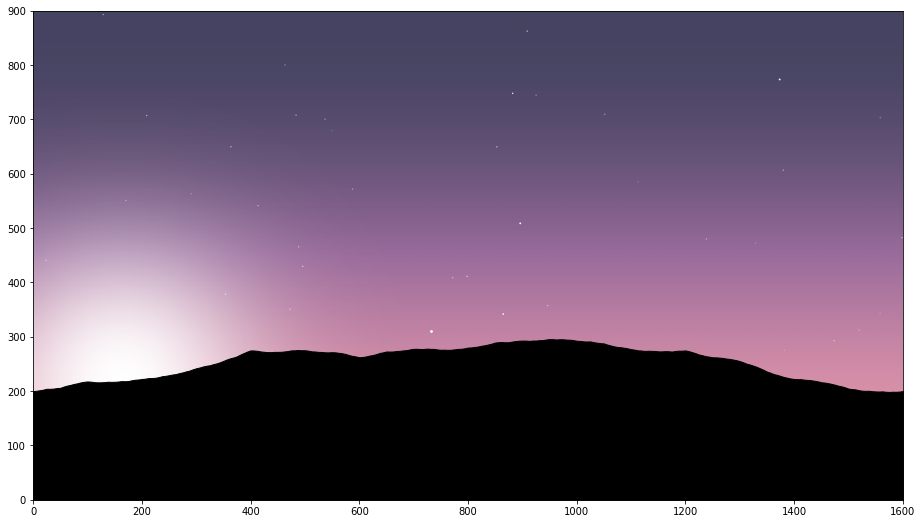

In [12]:
def makeGaussian(size, fwhm=3, center=None):
    """ Make a square gaussian kernel (https://stackoverflow.com/questions/7687679/how-to-generate-2d-gaussian-with-python)
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def draw_sun(w, h, center=None, size=None, terrain=None, col=[1,1,1]):
    # Find crop factor
    crop = int((max(w,h)-min(w,h))/2)
    # Set it at random (x) and near terrain (y)
    if terrain is not None:
        center_x = np.random.random() * w
        idx = np.argmin(np.abs(t[:,0]-center_x))
        center_y = t[idx,1]
        center = [center_x, center_y]
    # Else set it at random if not provided
    elif center is None:
        center = [np.random.random() * w, np.random.random() * h]
        print(center)
    # Adjust defined center position to allow cropping
    if w > h: center[1] += crop
    elif h > w: center[0] += crop
    # Set size
    if size is None: size = int(w / 5)
    # Make blob
    g = makeGaussian(max(w,h), fwhm=size, center=center)
    # Crop the larger axis
    if w > h: g = g[crop:-crop,:]
    elif h > w: g = g[:,crop:-crop]
    # Assign colour & transparency
    img = np.ones((h, w, 4))
    img[:,:,0:3] = img[:,:,0:3] * np.array(col) #set RGB colour
    img[:,:,3] = g #alpha channel
    # Draw
    plt.imshow(img, zorder=2)


plt.figure(figsize=(16,9))
draw_sky(w, h, sky1_cmap)
draw_stars(w, h, n=50)
t = draw_terrain([0, 200], [w, 200], 1.2, 80, 8)
draw_sun(w, h, size=400, terrain=t)
plt.show()

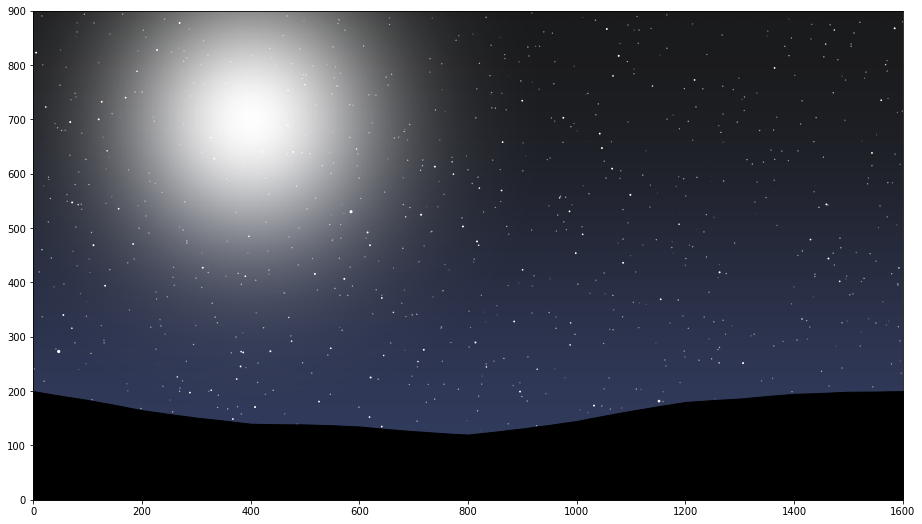

In [23]:
plt.figure(figsize=(16,9))
draw_sky(w, h, sky3_cmap)
draw_stars(w, h, n=1000)
t = draw_terrain([0, 200], [w, 200], 2, 80, 8)
draw_sun(w, h, size=400, center=[400,700])
plt.show()

In [15]:
# UI gradients (https://uigradients.com)

ui_dict = {
    'blue_lagoon':['#191654','#43C6AC'],
    'what_lies_beyond':['#000C40', '#F0F2F0'],
    'dawn':['#3B4371','#F3904F'],
    'ibiza_sunset':['#ee0979','#ff6a00'],
    'cosmic_fusion':['#333399','#ff00cc'],
    'nepal':['#2657eb','#de6161'],
    'love_couple':['#3a6186','#89253e'],
    'dania':['#BE93C5','#7BC6CC'],
    'jupiter':['#19547b','#ffd89b'],
    'dusk':['#2C3E50','#FD746C'],
    'deep_sea_space':['#2C3E50','#4CA1AF'],
    'grapefruit_sunset':['#904e95','#e96443'],
    'sunset':['#0B486B','#F56217'],
    'politics':['#2196f3','#f44336'],
    'sweet_morning':['#FF5F6D','#FFC371'],
    'transfile':['#CB3066','#16BFFD'],
    'alihossein':['#f7ff00','#db36a4'],
    'dark_skies':['#283E51','#4B79A1'],
    'shroom_haze':['#5C258D','#4389A2'],
    'electric_violet':['#4776E6','#8E54E9'],
    'kashmir':['#516395','#614385'],
    'crimson_tide':['#642B73','#C6426E']
}

ui_cmaps = {}
for k in ui_dict:
    ui_cmaps[k] = LinearSegmentedColormap.from_list(k, [(0.0, ui_dict[k][0]), (1.0, ui_dict[k][1])])
    
atlas = [(0.0, '#4BC0C8'), (0.5, '#C779D0'), (1.0, '#FEAC5E')]
ui_cmaps['atlas'] = LinearSegmentedColormap.from_list('atlas', atlas)

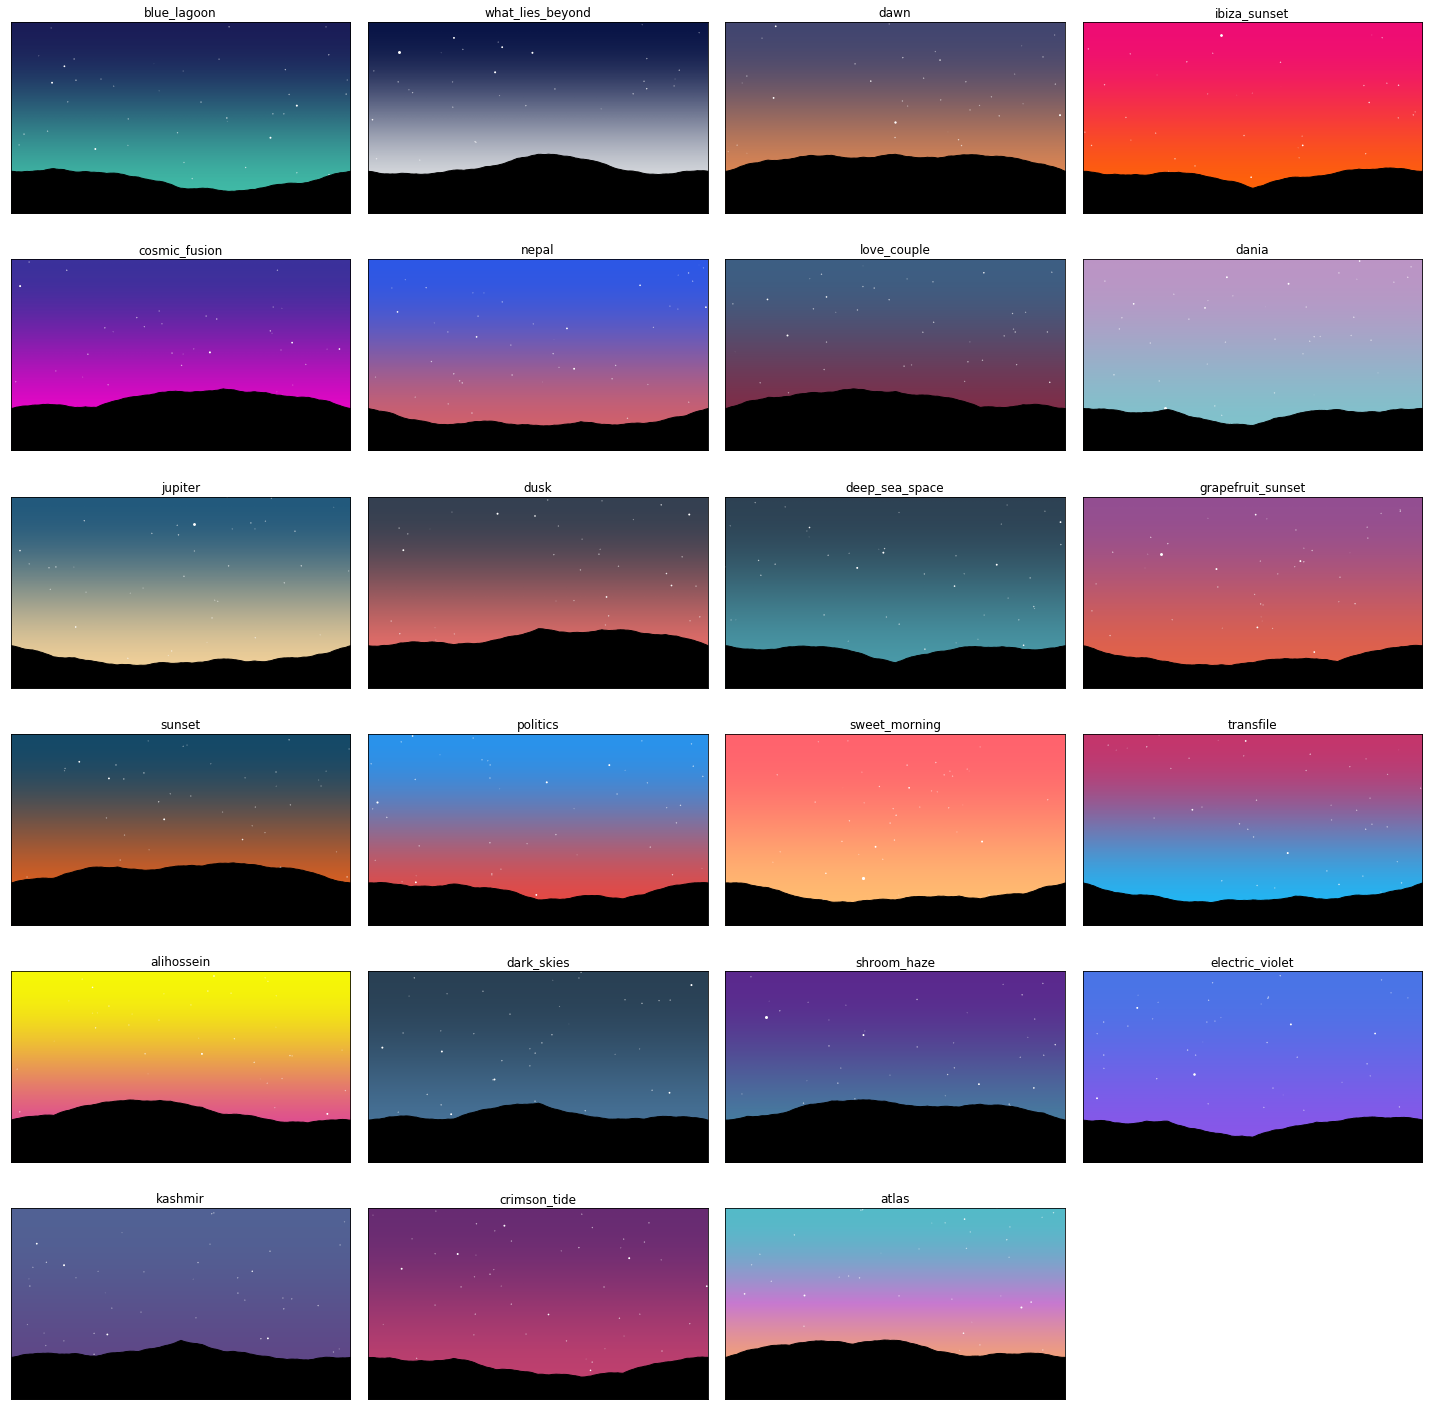

In [16]:
plt.figure(figsize=(20,20))
i = 1
for k in ui_cmaps:
    plt.subplot(6,4,i)
    draw_sky(w, h, ui_cmaps[k])
    draw_stars(w, h, n=50)
    t = draw_terrain([0, 200], [w, 200], 1.2, 80, 8)
    plt.title(k)
    plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)
    i += 1
    
plt.tight_layout()
plt.show()